# Using `tidyr` to create tidy data sets

**Description**
> Easily Tidy Data with 'spread()' and 'gather()' Functions

A tidy data frame is one where

- Each column is a variable
- Each row is an observatino
- Each value is a cell

As we have seen, tidy data sets can be easily plotted with `ggplot2` and manipulated with `dplyr`. In this notebook, we see how to convert messy data sets into tidy ones using the verbs `gather`, `spread`, `separate`, `extract`, `separte_rows` and `unite`.

For more complicated tidying jobs, see the full range of functions in the [`tidyr` documentation](https://cran.r-project.org/web/packages/tidyr/tidyr.pdf).

## Data

We will work with a subset of the pilot metadata that we are familiar with from the `dplyr` session.

In [3]:
path='../josh/info/2018_pilot_metadata.tsv'

In [4]:
df <- read_tsv(path)

Parsed with column specification:
cols(
  Label = col_character(),
  RNA_sample_num = col_integer(),
  Media = col_character(),
  Strain = col_character(),
  Replicate = col_integer(),
  experiment_person = col_character(),
  libprep_person = col_character(),
  enrichment_method = col_character(),
  RIN = col_double(),
  concentration_fold_difference = col_double(),
  `i7 index` = col_character(),
  `i5 index` = col_character(),
  `i5 primer` = col_character(),
  `i7 primer` = col_character(),
  `library#` = col_integer()
)


### Subset the data

In [10]:
df <- df %>% select(
    Label,
    RNA_sample_num,
    Media,
    Strain,
    Replicate,
    concentration_fold_difference,
    `i7 index`,
    `i5 index`,  
    `i5 primer`,
    `i7 primer`,
)

In [11]:
head(df)

Label   RNA_sample_num Media Strain Replicate concentration_fold_difference
1 2_MA_C   2             YPD   H99    2         1.34                         
2 9_MA_C   9             YPD   mar1d  3         2.23                         
3 10_MA_C 10             YPD   mar1d  4         4.37                         
4 14_MA_C 14             TC    H99    2         1.57                         
5 15_MA_C 15             TC    H99    3         2.85                         
6 21_MA_C 21             TC    mar1d  3         1.81                         
  i7 index i5 index i5 primer i7 primer
1 ATTACTCG AGGCTATA i501      i701     
2 ATTACTCG GCCTCTAT i502      i701     
3 ATTACTCG AGGATAGG i503      i701     
4 ATTACTCG TCAGAGCC i504      i701     
5 ATTACTCG CTTCGCCT i505      i701     
6 ATTACTCG TAAGATTA i506      i701

## 1. Use `gather` to combine multiple columns into one

We note thet there are two "index" and "primer" columns - for a tidy data frame, we probably want to combine them. We cna do this using `gather`.

### Warm-up

The use of `gather` can be confusing, so we will start with a toy example.

In [90]:
name <- c('ann', 'bob', 'charlie')
jan <- c(102, 155, 211)
feb <- c(112, 150, 211)
mar <- c(123, 147, 213)
apr <- c(130, 140, 210)

wts <- tibble(name=name, jan=jan, feb=feb, mar=mar, apr=apr)

In [91]:
wts

name    jan feb mar apr
1 ann     102 112 123 130
2 bob     155 150 147 140
3 charlie 211 211 213 210

### Messy data

In the current form, it is not possible to subgroup by month or to plot by month easily.

### Using `gather` to creat a new column called `weight` to store monthly weights

In [93]:
wts %>% gather(key=month, value=weight, jan:apr)

name    month weight
1  ann     jan   102   
2  bob     jan   155   
3  charlie jan   211   
4  ann     feb   112   
5  bob     feb   150   
6  charlie feb   211   
7  ann     mar   123   
8  bob     mar   147   
9  charlie mar   213   
10 ann     apr   130   
11 bob     apr   140   
12 charlie apr   210

In [97]:
wts.1 <- wts %>% gather(key=month, value=weight, jan:apr)

### To get menth sorted correctly, we make it a factor

In [102]:
wts.1 %>% mutate(month = factor(month, 
                                ordered = TRUE, 
                                levels = c('jan', 'feb', 'mar', 'apr')))

name    month weight
1  ann     jan   102   
2  bob     jan   155   
3  charlie jan   211   
4  ann     feb   112   
5  bob     feb   150   
6  charlie feb   211   
7  ann     mar   123   
8  bob     mar   147   
9  charlie mar   213   
10 ann     apr   130   
11 bob     apr   140   
12 charlie apr   210

In [103]:
wts.2 <- wts.1 %>% mutate(month = factor(month, 
                                ordered = TRUE, 
                                levels = c('jan', 'feb', 'mar', 'apr')))

### Now we can easily work wtih the tidy data set

In [106]:
wts.2 %>% 
group_by(month) %>% 
summarize_at('weight', funs(min, max, mean)) 

month min max mean    
1 jan   102 211 156.0000
2 feb   112 211 157.6667
3 mar   123 213 161.0000
4 apr   130 210 160.0000

In [119]:
options(repr.plot.width=6, repr.plot.height=3)

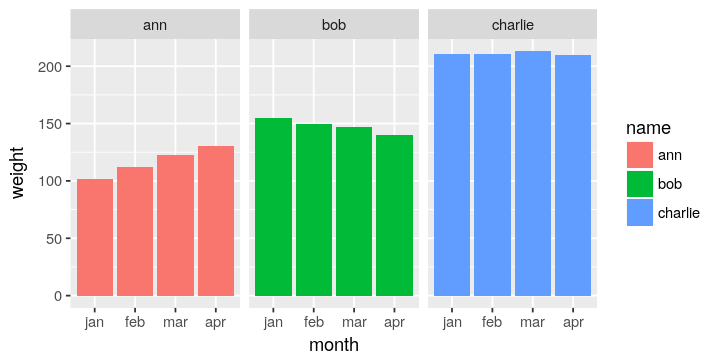

In [120]:
ggplot(wts.2, aes(x=month, y=weight, fill=name)) + 
geom_bar(stat='identity') + 
facet_wrap('name')

### Using `gather` on experiment metadata

In [235]:
df %>% 
select(Label, ends_with('index')) %>% 
head()

Label   i7 index i5 index
1 2_MA_C  ATTACTCG AGGCTATA
2 9_MA_C  ATTACTCG GCCTCTAT
3 10_MA_C ATTACTCG AGGATAGG
4 14_MA_C ATTACTCG TCAGAGCC
5 15_MA_C ATTACTCG CTTCGCCT
6 21_MA_C ATTACTCG TAAGATTA

In [237]:
df %>% 
select(Label, ends_with('index')) %>% 
gather(index, sequence, -Label) %>% 
head()

Label   index    sequence
1 2_MA_C  i7 index ATTACTCG
2 9_MA_C  i7 index ATTACTCG
3 10_MA_C i7 index ATTACTCG
4 14_MA_C i7 index ATTACTCG
5 15_MA_C i7 index ATTACTCG
6 21_MA_C i7 index ATTACTCG

In [239]:
df %>% 
select(Label, ends_with('index')) %>% 
gather(index, sequence, -Label) %>% 
mutate(index=str_extract(index, '^..')) %>%
head()

Label   index sequence
1 2_MA_C  i7    ATTACTCG
2 9_MA_C  i7    ATTACTCG
3 10_MA_C i7    ATTACTCG
4 14_MA_C i7    ATTACTCG
5 15_MA_C i7    ATTACTCG
6 21_MA_C i7    ATTACTCG

## 2. Use `spread` to convert one column into multiple

We can undo `gather` with `spread`. This is less commonly used than `gather`.

In [240]:
df %>% 
select(Label, ends_with('index')) %>% 
gather(index, sequence, -Label) %>% 
head()

Label   index    sequence
1 2_MA_C  i7 index ATTACTCG
2 9_MA_C  i7 index ATTACTCG
3 10_MA_C i7 index ATTACTCG
4 14_MA_C i7 index ATTACTCG
5 15_MA_C i7 index ATTACTCG
6 21_MA_C i7 index ATTACTCG

In [241]:
df %>% 
select(Label, ends_with('index')) %>% 
gather(index, sequence, -Label) %>% 
spread(index, sequence) %>%
head()

Label   i5 index i7 index
1 1_MA_J  AGGCTATA CGCTCATT
2 1_RZ_J  AGGCTATA GAGATTCC
3 10_MA_C AGGATAGG ATTACTCG
4 10_RZ_C AGGATAGG TCCGGAGA
5 11_MA_J AGGATAGG CGCTCATT
6 11_RZ_J AGGATAGG GAGATTCC

## 3. Use `separate` to split a single column containing multiple values

The label column actually contains three pieces of informaiton separated by underscores - a sample number, the RNA enrichment methd, and code for the person presenting the sample. Assuuming that we do not have this informatio nduplicate in other columns, it woujld be tricky to compare, say, results by the sampling method.

The `separate` function is designed to address this problem.

In [246]:
df %>% 
select(Label, concentration_fold_difference) %>% 
head(3)

Label   concentration_fold_difference
1 2_MA_C  1.34                         
2 9_MA_C  2.23                         
3 10_MA_C 4.37

In [249]:
df %>% 
select(Label, concentration_fold_difference) %>% 
separate(Label, sep='_', into=c('sample_num', 'enrichment', 'person')) %>%
head(3)

sample_num enrichment person concentration_fold_difference
1 2          MA         C      1.34                         
2 9          MA         C      2.23                         
3 10         MA         C      4.37

#### It is now easy to condition on sample_number, enrichment method or person

Here is a summary of the data.

In [278]:
df %>% 
select(Label, concentration_fold_difference) %>% 
separate(Label, into=c('sample_num', 'enrichment', 'person'), sep='_') %>%
add_count(enrichment) %>%
group_by(person, enrichment, n) %>%
summarize_at('concentration_fold_difference', mean) 

person enrichment n  concentration_fold_difference
1 C      MA         24 2.3675                       
2 C      RZ         24 2.3675                       
3 C      TOT         3 1.3400                       
4 J      MA         24 3.4350                       
5 J      RZ         24 3.4350                       
6 J      TOT         3 1.9800                       
7 P      MA         24 3.0800                       
8 P      RZ         24 3.0800                       
9 P      TOT         3 2.0500

## 4. Use `unite` to craate a single variable from multiple columns

Sometimes we want to do the opposite and combine multiple columns into a single column. Use `unite` to do this.

In [276]:
df %>% 
select(Label, concentration_fold_difference) %>% 
separate(Label, sep='_', into=c('sample_num', 'enrichment', 'person')) %>%
head

sample_num enrichment person concentration_fold_difference
1 2          MA         C      1.34                         
2 9          MA         C      2.23                         
3 10         MA         C      4.37                         
4 14         MA         C      1.57                         
5 15         MA         C      2.85                         
6 21         MA         C      1.81

In [277]:
df %>% 
select(Label, concentration_fold_difference) %>% 
separate(Label, sep='_', into=c('sample_num', 'enrichment', 'person')) %>%
unite(Label, c('sample_num', 'enrichment', 'person'), sep='_') %>% 
head

Label   concentration_fold_difference
1 2_MA_C  1.34                         
2 9_MA_C  2.23                         
3 10_MA_C 4.37                         
4 14_MA_C 1.57                         
5 15_MA_C 2.85                         
6 21_MA_C 1.81

#### Extract parts with regular expressions

Sometiems there is no simple delimiter between parts of a value. In such cases, we may need to use reuglar expressions to extract parts from a string.

In [293]:
bad_labels <- df %>% 
select(Label, concentration_fold_difference) %>% 
separate(Label, 
         sep='_', 
         into=c('sample_num', 'enrichment', 'person')) %>%
unite(Label, c('sample_num', 'enrichment', 'person'), sep='')
head(bad_labels)

Label concentration_fold_difference
1 2MAC  1.34                         
2 9MAC  2.23                         
3 10MAC 4.37                         
4 14MAC 1.57                         
5 15MAC 2.85                         
6 21MAC 1.81

The regular expression consists of 3 capture groups in parentheses that will form the new columns.

`'([0-9]+)(.*)(.$)'`

where

- Capture group 1 `[0-9]+`  means match one or more `+` of any digits  `[0-9]`
- Capture group 2 `.*`     means match zero or more `*` of any character `.`
- Capture gorup 3 `.$`     means match any character `.` at the end `$`

In [306]:
bad_labels %>% 
extract(Label, 
         into=c('sample_num', 'enrichment', 'person'), 
         '([0-9]+)(.*)(.$)') %>%
head

sample_num enrichment person concentration_fold_difference
1 2          MA         C      1.34                         
2 9          MA         C      2.23                         
3 10         MA         C      4.37                         
4 14         MA         C      1.57                         
5 15         MA         C      2.85                         
6 21         MA         C      1.81

### Using `separate_rows` rows when multiple values are in a single cell.

Very occassionally, we find data sets where multiple values are stored in a single cell. We will make up and exmple here as this does not occur in the metadata data set.

In [330]:
bad_primer <- df %>% 
select(Label, `i5 index`, `i7 index`) %>% 
unite(primer, c(`i5 index`, `i7 index`), sep=',') %>%
arrange(Label)
head(bad_primer)

Label   primer           
1 1_MA_J  AGGCTATA,CGCTCATT
2 1_RZ_J  AGGCTATA,GAGATTCC
3 10_MA_C AGGATAGG,ATTACTCG
4 10_RZ_C AGGATAGG,TCCGGAGA
5 11_MA_J AGGATAGG,CGCTCATT
6 11_RZ_J AGGATAGG,GAGATTCC

In [331]:
bad_primer %>% 
separate_rows(primer, sep=',') %>%
head

Label   primer  
1 1_MA_J  AGGCTATA
2 1_MA_J  CGCTCATT
3 1_RZ_J  AGGCTATA
4 1_RZ_J  GAGATTCC
5 10_MA_C AGGATAGG
6 10_MA_C ATTACTCG

#### Challenge: Reconstruct column structure  of orignial metadata file

Since `separate_rows` will place the items in each row in alternating columns, we create a temporary variable to store the position in the original cell.

In [332]:
bad_primer %>% 
separate_rows(primer, sep=',') %>%
mutate(tmp=rep_len(1:2, n())) %>% 
head

Label   primer   tmp
1 1_MA_J  AGGCTATA 1  
2 1_MA_J  CGCTCATT 2  
3 1_RZ_J  AGGCTATA 1  
4 1_RZ_J  GAGATTCC 2  
5 10_MA_C AGGATAGG 1  
6 10_MA_C ATTACTCG 2

We then `spread` the primer values by the temporary variable and rename the columns as appropriate.

In [333]:
bad_primer %>% 
separate_rows(primer, sep=',') %>%
mutate(tmp=rep_len(1:2, n())) %>% 
spread(tmp, primer) %>%
rename(`i5 index`=`1`, `i7 index`=`2`) %>%
head

Label   i5 index i7 index
1 1_MA_J  AGGCTATA CGCTCATT
2 1_RZ_J  AGGCTATA GAGATTCC
3 10_MA_C AGGATAGG ATTACTCG
4 10_RZ_C AGGATAGG TCCGGAGA
5 11_MA_J AGGATAGG CGCTCATT
6 11_RZ_J AGGATAGG GAGATTCC

Comapre with original

In [334]:
df %>%
select(Label, `i5 index`, `i7 index`) %>%
arrange(Label) %>%
head

Label   i5 index i7 index
1 1_MA_J  AGGCTATA CGCTCATT
2 1_RZ_J  AGGCTATA GAGATTCC
3 10_MA_C AGGATAGG ATTACTCG
4 10_RZ_C AGGATAGG TCCGGAGA
5 11_MA_J AGGATAGG CGCTCATT
6 11_RZ_J AGGATAGG GAGATTCC

## Challenge exercise 

Let's look at the index and primer columne more closely. It seems that the index and primer values are linked and are just different ways of labeling the same thing. So we really should be have columns like this

| primer_type | code | seq |
| - | - | - |
| i5 | i501 | AGGCTATA | 
| i5 | i502 | GCCTCTAT |
| i7 | i701 | ATTACTCG |
| i7 | i702 | TCCGGAGA |

We can do this by combining the operatios we have seen above.

In [232]:
df %>% 
unite(i7, c(`i7 primer`, `i7 index`), sep=':') %>%
unite(i5, c(`i5 primer`, `i5 index`), sep=':') %>%
gather(primer_type, val, c(i7, i5)) %>%
separate(val, into=c('code', 'seq'), sep=':') %>%
mutate(code=str_extract(code, '..$')) %>%
arrange(primer_type, code) %>% 
head(10)

Label   RNA_sample_num Media Strain Replicate concentration_fold_difference
1  2_MA_C  2              YPD   H99    2         1.34                         
2  2_RZ_C  2              YPD   H99    2         1.34                         
3  2_TOT_C 2              YPD   H99    2         1.34                         
4  1_MA_J  1              YPD   H99    1         3.64                         
5  1_RZ_J  1              YPD   H99    1         3.64                         
6  4_MA_P  4              YPD   H99    4         2.05                         
7  4_RZ_P  4              YPD   H99    4         2.05                         
8  9_MA_C  9              YPD   mar1d  3         2.23                         
9  9_RZ_C  9              YPD   mar1d  3         2.23                         
10 3_MA_J  3              YPD   H99    3         1.98                         
   primer_type code seq     
1  i5          01   AGGCTATA
2  i5          01   AGGCTATA
3  i5          01   AGGCTATA
4  i5          01   AGGCTATA
5  i5          01   AGGCTATA
6  i5          01   AGGCTATA
7  i5          01   AGGCTATA
8  i5          02   GCCTCTAT
9  i5          02   GCCTCTAT
10 i5          02   GCCTCTAT